## Business Understanding

In this project, we aim to find the likelihood of a customer leaving the organization, the key indicators of churn as well as the retention strategies that can be implemented to avert this problem.

__Hypothesis__

H0: Customers with shorter tenure are more likely to churn.

H1: The tenure of customers has no significant impact on churn.

__Analytical Questions__



1. What is the overall churn rate in the dataset?

2. Which InternetService type (DSL, Fiber optic) has the highest churn rate?

3. What is the distribution of customers based on gender, senior citizen status, partner, and dependents?

4. Is there a significant difference in churn rates between customers with month-to-month contracts and those with longer-term contracts?

5. Are there specific payment methods associated with higher or lower churn?

6. Among customers with DSL and fiber optic internet, which group has a higher churn rate?

7. How does the provision of phone service (True/False) influence customer churn?

__Load Packages__

In [1]:
# import all necessary packages

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib
import os
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import PowerTransformer
from imblearn.over_sampling import SMOTE,RandomOverSampler
import pyodbc 
from dotenv import dotenv_values 
import pandas as pd
import scipy.stats as stats
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder,FunctionTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load environment variables from .env file into a dictionary

environment_variables = dotenv_values('.env')

# Get the values for the credentials you set in the '.env' file

database = environment_variables.get("database")
server = environment_variables.get("server")
username = environment_variables.get("username")
password = environment_variables.get("password")

conn_str = f'DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}'

In [3]:
# create connection

connection = pyodbc.connect(conn_str)

In [4]:
# Now the sql query to get the data 


# SQL query
query = "SELECT * FROM dbo.LP2_Telco_churn_first_3000"


Load dataset

In [5]:
# Read data into a DataFrame



df = pd.read_sql(query, connection)


In [6]:
#preview data
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2209-XADXF,Female,False,False,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,False,Bank transfer (automatic),25.250000,25.250000,False
2996,6620-JDYNW,Female,False,False,False,18,True,True,DSL,True,...,True,False,False,False,Month-to-month,True,Mailed check,60.599998,1156.349976,False
2997,1891-FZYSA,Male,True,True,False,69,True,True,Fiber optic,False,...,False,False,True,False,Month-to-month,True,Electronic check,89.949997,6143.149902,True
2998,4770-UEZOX,Male,False,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,74.750000,144.800003,False


Check the number of rows and columns in the dataset

In [7]:
df.shape

(3000, 21)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        3000 non-null   object 
 1   gender            3000 non-null   object 
 2   SeniorCitizen     3000 non-null   bool   
 3   Partner           3000 non-null   bool   
 4   Dependents        3000 non-null   bool   
 5   tenure            3000 non-null   int64  
 6   PhoneService      3000 non-null   bool   
 7   MultipleLines     2731 non-null   object 
 8   InternetService   3000 non-null   object 
 9   OnlineSecurity    2349 non-null   object 
 10  OnlineBackup      2349 non-null   object 
 11  DeviceProtection  2349 non-null   object 
 12  TechSupport       2349 non-null   object 
 13  StreamingTV       2349 non-null   object 
 14  StreamingMovies   2349 non-null   object 
 15  Contract          3000 non-null   object 
 16  PaperlessBilling  3000 non-null   bool   


In [9]:
df_1 = pd.read_csv('LP2_Telco-churn-second-2000.csv')

df_1

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5600-PDUJF,Male,0,No,No,6,Yes,No,DSL,No,...,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),49.50,312.7,No
1,8292-TYSPY,Male,0,No,No,19,Yes,No,DSL,No,...,Yes,Yes,No,No,Month-to-month,Yes,Credit card (automatic),55.00,1046.5,Yes
2,0567-XRHCU,Female,0,Yes,Yes,69,No,No phone service,DSL,Yes,...,Yes,No,No,Yes,Two year,Yes,Credit card (automatic),43.95,2960.1,No
3,1867-BDVFH,Male,0,Yes,Yes,11,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,74.35,834.2,Yes
4,2067-QYTCF,Female,0,Yes,No,64,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,111.15,6953.4,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
2039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
2040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
2041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [10]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2043 entries, 0 to 2042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2043 non-null   object 
 1   gender            2043 non-null   object 
 2   SeniorCitizen     2043 non-null   int64  
 3   Partner           2043 non-null   object 
 4   Dependents        2043 non-null   object 
 5   tenure            2043 non-null   int64  
 6   PhoneService      2043 non-null   object 
 7   MultipleLines     2043 non-null   object 
 8   InternetService   2043 non-null   object 
 9   OnlineSecurity    2043 non-null   object 
 10  OnlineBackup      2043 non-null   object 
 11  DeviceProtection  2043 non-null   object 
 12  TechSupport       2043 non-null   object 
 13  StreamingTV       2043 non-null   object 
 14  StreamingMovies   2043 non-null   object 
 15  Contract          2043 non-null   object 
 16  PaperlessBilling  2043 non-null   object 


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        3000 non-null   object 
 1   gender            3000 non-null   object 
 2   SeniorCitizen     3000 non-null   bool   
 3   Partner           3000 non-null   bool   
 4   Dependents        3000 non-null   bool   
 5   tenure            3000 non-null   int64  
 6   PhoneService      3000 non-null   bool   
 7   MultipleLines     2731 non-null   object 
 8   InternetService   3000 non-null   object 
 9   OnlineSecurity    2349 non-null   object 
 10  OnlineBackup      2349 non-null   object 
 11  DeviceProtection  2349 non-null   object 
 12  TechSupport       2349 non-null   object 
 13  StreamingTV       2349 non-null   object 
 14  StreamingMovies   2349 non-null   object 
 15  Contract          3000 non-null   object 
 16  PaperlessBilling  3000 non-null   bool   


In [12]:
# # this function will be called again during encoding
# # encoder function

# def label_encode_column(dataframe, column_name):
#     label_encoder = LabelEncoder()
#     dataframe[column_name] = label_encoder.fit_transform(dataframe[column_name])
#     return dataframe





In [13]:

# # Encode 'SeniorCitizen' column using the function
# label_encode_column(df, 'SeniorCitizen')

# # preview the updated Data
# df_encode

In [14]:
data = pd.concat([df,df_1], axis=0, ignore_index=True)

In [15]:

data

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.85,False
1,5575-GNVDE,Male,0,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.5,False
2,3668-QPYBK,Male,0,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,0,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.75,False
4,9237-HQITU,Female,0,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.800000,1990.5,No
5039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.200000,7362.9,No
5040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.600000,346.45,No
5041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.400000,306.6,Yes


## Data understanding

__Exploratory Data Analysis__

Identify any missing values

In [16]:
# check null values

data.isna().sum()


customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          5
Churn                 1
dtype: int64

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5043 non-null   object 
 1   gender            5043 non-null   object 
 2   SeniorCitizen     5043 non-null   int64  
 3   Partner           5043 non-null   object 
 4   Dependents        5043 non-null   object 
 5   tenure            5043 non-null   int64  
 6   PhoneService      5043 non-null   object 
 7   MultipleLines     4774 non-null   object 
 8   InternetService   5043 non-null   object 
 9   OnlineSecurity    4392 non-null   object 
 10  OnlineBackup      4392 non-null   object 
 11  DeviceProtection  4392 non-null   object 
 12  TechSupport       4392 non-null   object 
 13  StreamingTV       4392 non-null   object 
 14  StreamingMovies   4392 non-null   object 
 15  Contract          5043 non-null   object 
 16  PaperlessBilling  5043 non-null   object 


Get summary statistics for numerical columns.

In [18]:
# Display summary statistics for numerical columns

data.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,5043.0,0.162403,0.368857,0.0,0.000,0.000000,0.000000,1.000000
tenure,5043.0,32.576641,24.529807,0.0,9.000,29.000000,56.000000,72.000000
MonthlyCharges,5043.0,65.090214,30.068133,18.4,35.775,70.550003,90.050003,118.650002


In [19]:
# check duplicates in the customerID

dups= data[data.duplicated(subset=['customerID'], keep=False)]

dups

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


Explore unique values and their counts for categorical columns.

In [20]:
# Display unique values and value counts for categorical columns

for column in data.select_dtypes(include=['object']).columns:
  
    count = data['Churn'].value_counts()

count

Churn
False    2219
No       1487
True      780
Yes       556
Name: count, dtype: int64

replace yes and no in "Churn"

In [21]:

# Replace 'Yes' and 'True' with 1 in the 'Churn' column

data['Churn'] = data['Churn'].replace({'Yes':True,  'No':False})

__Univariate Analysis__

Create histograms, box plots, and a scatter plot to better understand the distributions and relationships between the 'tenure,' 'MonthlyCharges,' and 'TotalCharges' variables. 

In [22]:
data['TotalCharges'].unique()

array([29.850000381469727, 1889.5, 108.1500015258789, ..., '346.45',
       '306.6', '6844.5'], dtype=object)

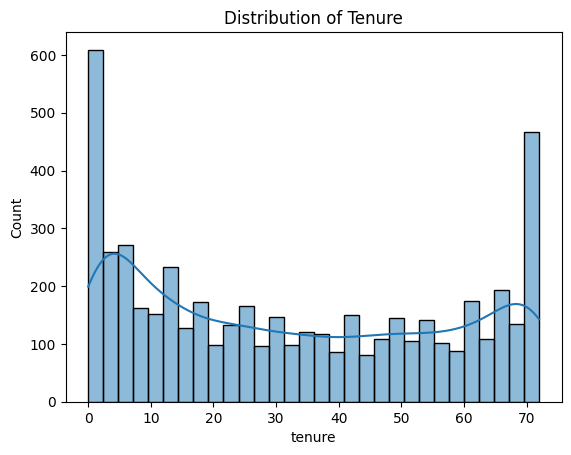

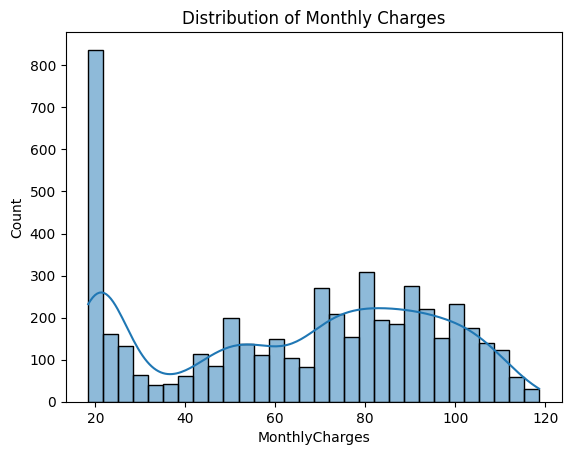

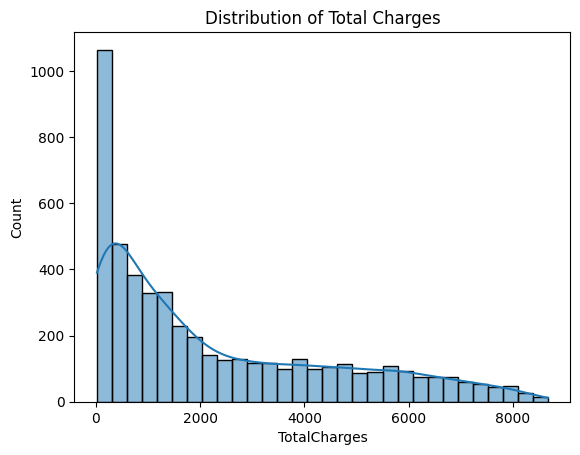

In [23]:
# Histogram for tenure
sns.histplot(data['tenure'], bins=30, kde=True)
plt.title("Distribution of Tenure")
plt.show()

# Histogram for MonthlyCharges
sns.histplot(data['MonthlyCharges'], bins=30, kde=True)
plt.title("Distribution of Monthly Charges")
plt.show()

# Histogram for TotalCharges 
#changing the total charge data type from object to float
data['TotalCharges']=pd.to_numeric(data['TotalCharges'], errors='coerce').astype('float')

sns.histplot(data['TotalCharges'].astype(float), bins=30, kde=True)
plt.title("Distribution of Total Charges")
plt.show()


array([[<Axes: title={'center': 'SeniorCitizen'}>,
        <Axes: title={'center': 'tenure'}>],
       [<Axes: title={'center': 'MonthlyCharges'}>,
        <Axes: title={'center': 'TotalCharges'}>]], dtype=object)

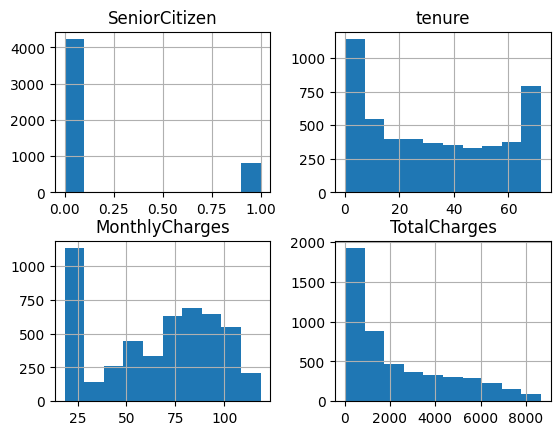

In [24]:
data.hist()

<function matplotlib.pyplot.show(close=None, block=None)>

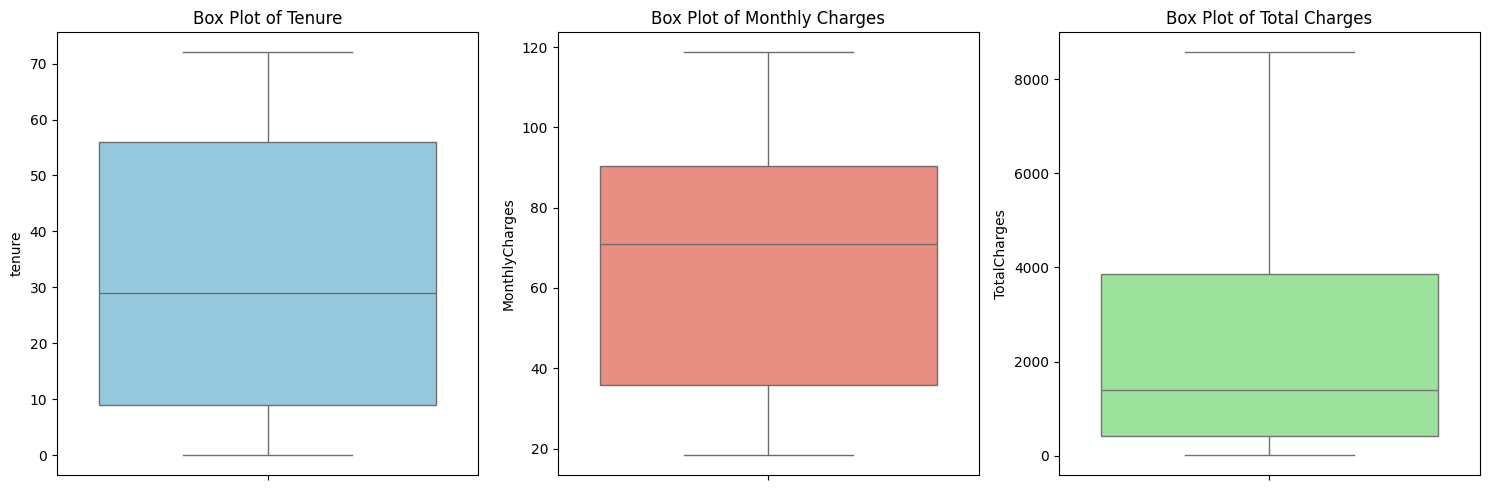

In [25]:
# Box Plots
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(y=df['tenure'], color='skyblue')
plt.title('Box Plot of Tenure')

plt.subplot(1, 3, 2)
sns.boxplot(y=df['MonthlyCharges'], color='salmon')
plt.title('Box Plot of Monthly Charges')

plt.subplot(1, 3, 3)
sns.boxplot(y=df['TotalCharges'].dropna(), color='lightgreen')
plt.title('Box Plot of Total Charges')

plt.tight_layout()
plt.show

__Count of Categorical Variables:__

+ Plot bar charts to visualize the count of categorical variables like gender, InternetService, and PaymentMethod.


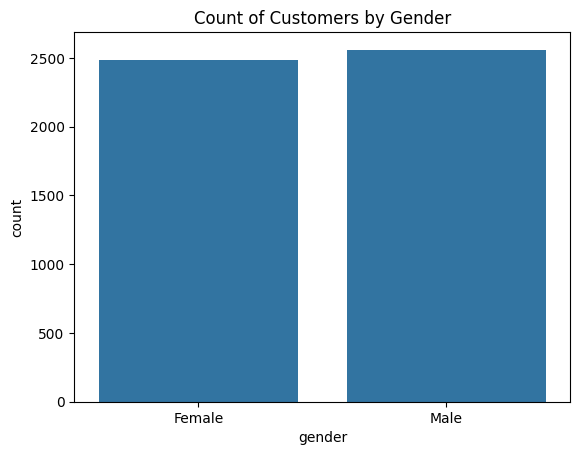

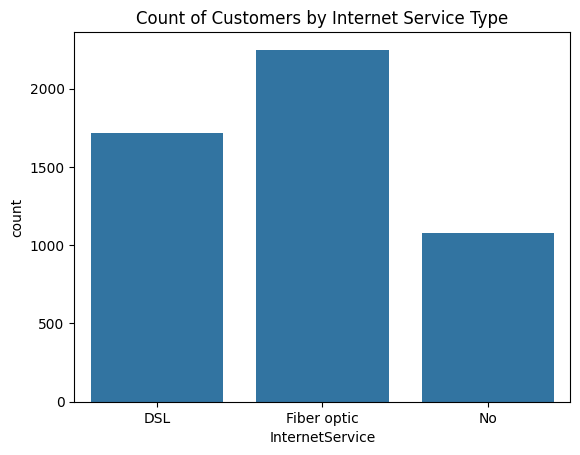

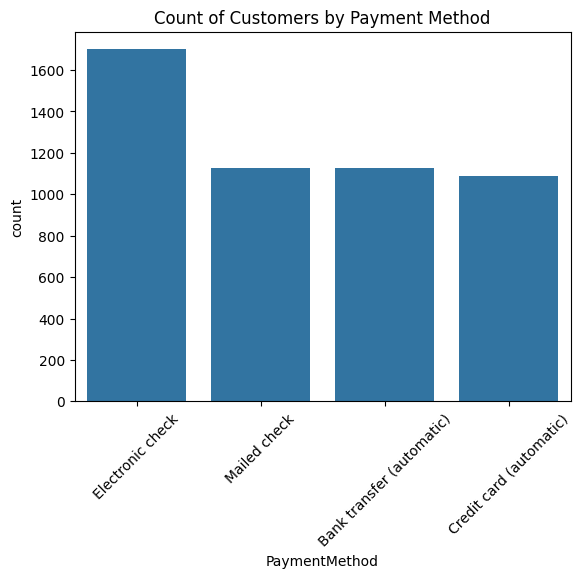

In [26]:
# Bar chart for gender
sns.countplot(x="gender", data=data)
plt.title("Count of Customers by Gender")
plt.show()

# Bar chart for InternetService
sns.countplot(x="InternetService", data=data)
plt.title("Count of Customers by Internet Service Type")
plt.show()

# Bar chart for PaymentMethod
sns.countplot(x="PaymentMethod", data=data)
plt.title("Count of Customers by Payment Method")
plt.xticks(rotation=45)
plt.show()


__Churn Distribution:__

Analyze the distribution Churn.


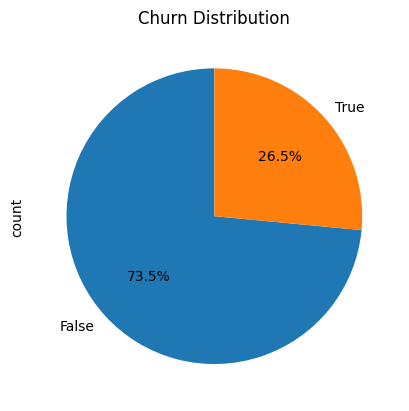

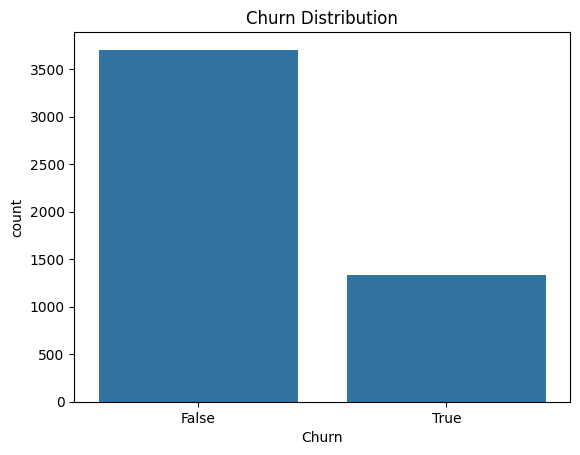

In [27]:
# Pie chart for Churn distribution
data['Churn'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.title("Churn Distribution")
plt.show()

# Bar chart for Churn distribution
#Drop rows with NaN values in 'Churn' column

drop_nan = data.dropna(subset=['Churn'])
sns.countplot(x='Churn', data=drop_nan)
plt.title("Churn Distribution")
plt.show()


__Bi-Variate Analysis__

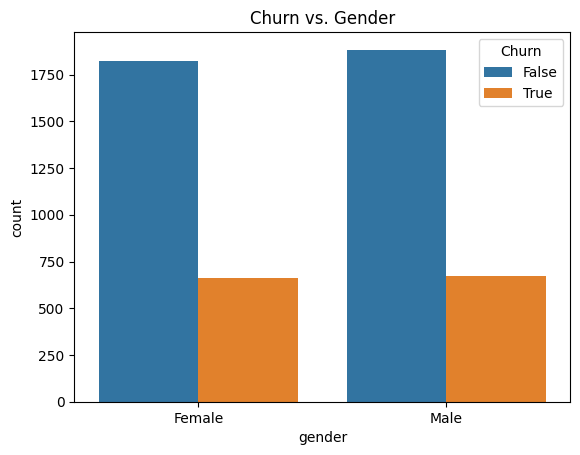

In [28]:
# Churn vs. Gender

sns.countplot(x="gender", hue="Churn", data=drop_nan)
plt.title("Churn vs. Gender")
plt.show()

Investigate how the monthly charges vary for customers who have churned compared to those who haven't.

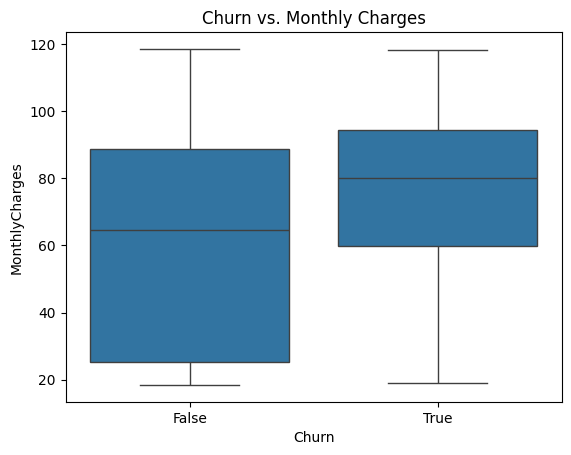

In [29]:

# Boxplot for Churn vs. Monthly Charges

sns.boxplot(x='Churn', y='MonthlyCharges', data=drop_nan)
plt.title('Churn vs. Monthly Charges')
plt.show()


Explore the relationship between customer tenure and churn.

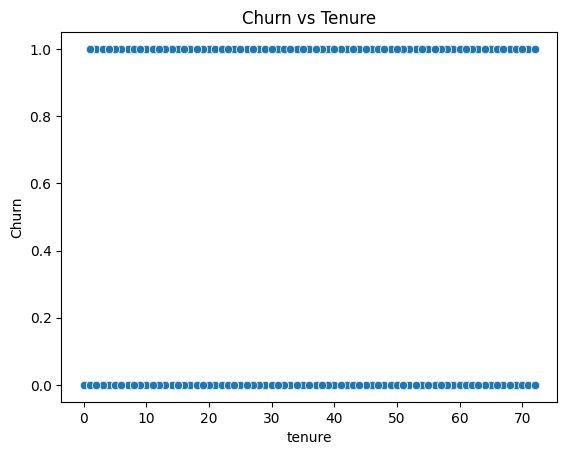

In [30]:
sns.scatterplot(x="tenure", y='Churn', data=drop_nan)
plt.title('Churn vs Tenure')
plt.show()

Analyze how the type of contract relates to customer churn.

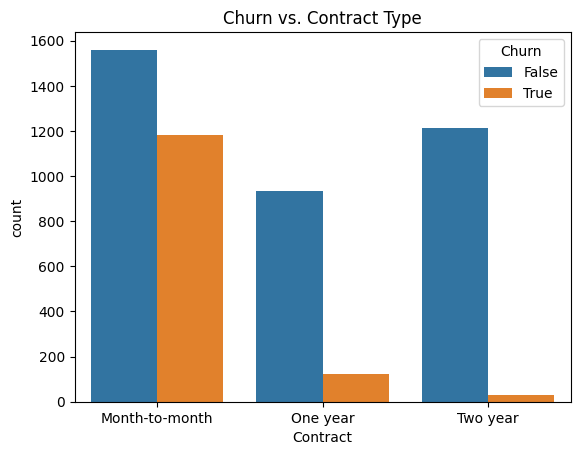

In [31]:
# Count plot for Churn vs. Contract Type

sns.countplot(x='Contract', hue='Churn', data=drop_nan)
plt.title('Churn vs. Contract Type')
plt.show()


Investigate the impact of different internet service types on customer churn.

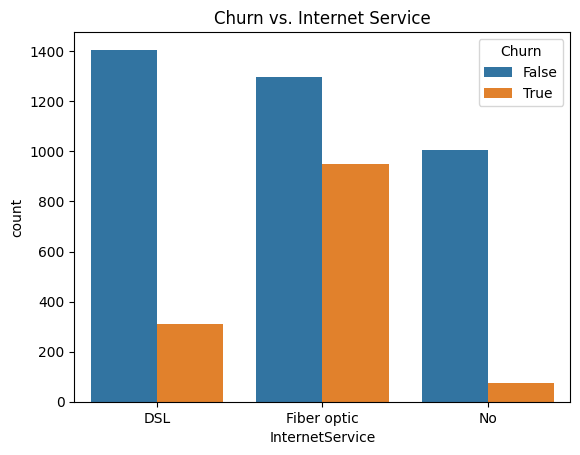

In [32]:
# Count plot for Churn vs. Internet Service

sns.countplot(x='InternetService', hue='Churn', data=drop_nan)
plt.title('Churn vs. Internet Service')
plt.show()


 Monthly Charges across different contract types

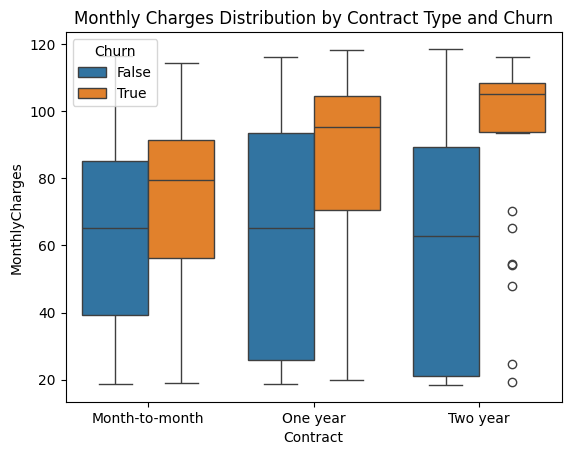

In [33]:
# Boxplot for Monthly Charges across different contract types

sns.boxplot(x='Contract', y='MonthlyCharges', hue='Churn', data=drop_nan)
plt.title('Monthly Charges Distribution by Contract Type and Churn')
plt.show()


PCA is a dimensionality reduction technique that helps identify patterns and relationships in high-dimensional data.

In [34]:
# drop nan in TotalCharges

data = data.dropna(subset='TotalCharges')

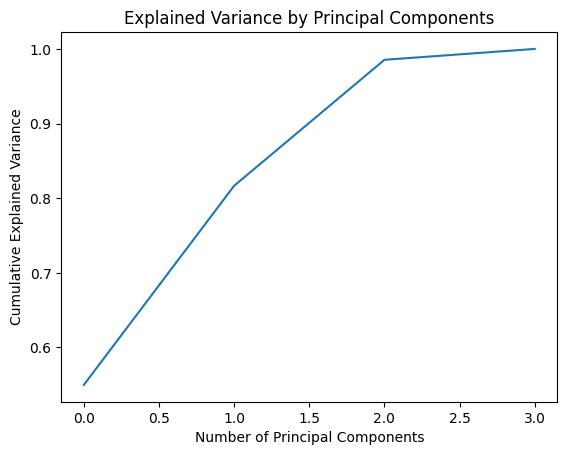

In [35]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Extract numerical features
numerical_features = data.select_dtypes(include=['float64', 'int64'])

# Standardize the data
scaler = StandardScaler()
standardized_data = scaler.fit_transform(numerical_features)

# Apply PCA
pca = PCA()
pca_result = pca.fit_transform(standardized_data)

# Plot explained variance ratio
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.show()


Explore unique values and their counts for categorical columns.

In [36]:
# Display unique values and value counts for categorical columns

for column in df.select_dtypes(include=['object']).columns:
  
    unique_values = data[column].value_counts()

  
unique_values

Churn
False    3698
True     1336
Name: count, dtype: int64

correlation

In [37]:


numeric_data = data.select_dtypes(include='number')
correlation = numeric_data.corr()

# correlation = data.corr()

correlation

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
SeniorCitizen,1.000000,0.003674,0.221585,0.095212
tenure,0.003674,1.000000,0.240001,0.826264
MonthlyCharges,0.221585,0.240001,1.000000,0.647007
TotalCharges,0.095212,0.826264,0.647007,1.000000


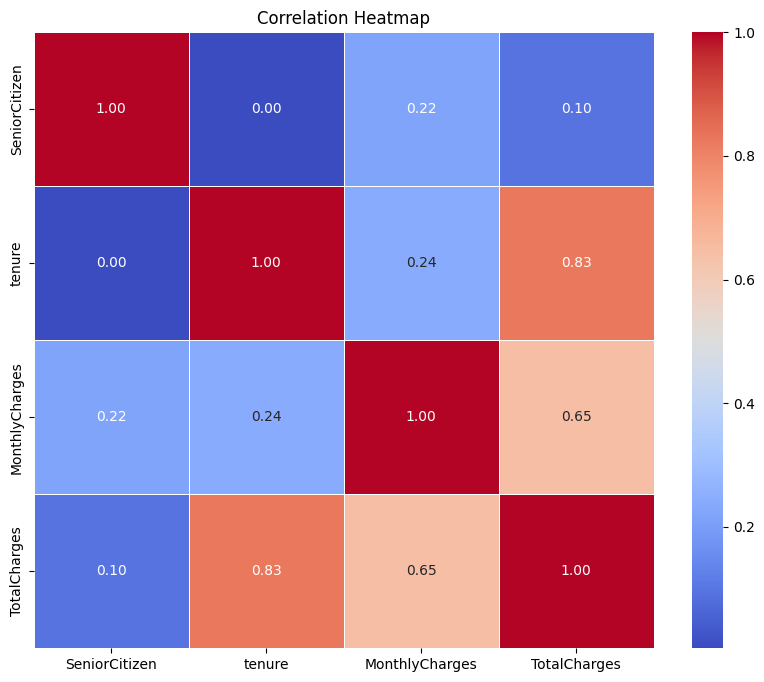

In [38]:
# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

In [39]:
data

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,0,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,0,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,0,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,9237-HQITU,Female,0,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.800000,1990.500000,False
5039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.200000,7362.900000,False
5040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.600000,346.450000,False
5041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.400000,306.600000,True


__Question 1__

What is the overall churn rate in the dataset?

In [40]:
data['Churn'].value_counts()

Churn
False    3698
True     1336
Name: count, dtype: int64

In [41]:
# Calculate the rate

total_customers = len(data) # total customers in the dataset

# total number of churned cutomers
churned_customers = data['Churn'].sum()

churned_customers

1336

In [42]:
churn_rate = (churned_customers / total_customers) * 100

print(f'Churn Rate: {churn_rate:.2f}%')

Churn Rate: 26.53%


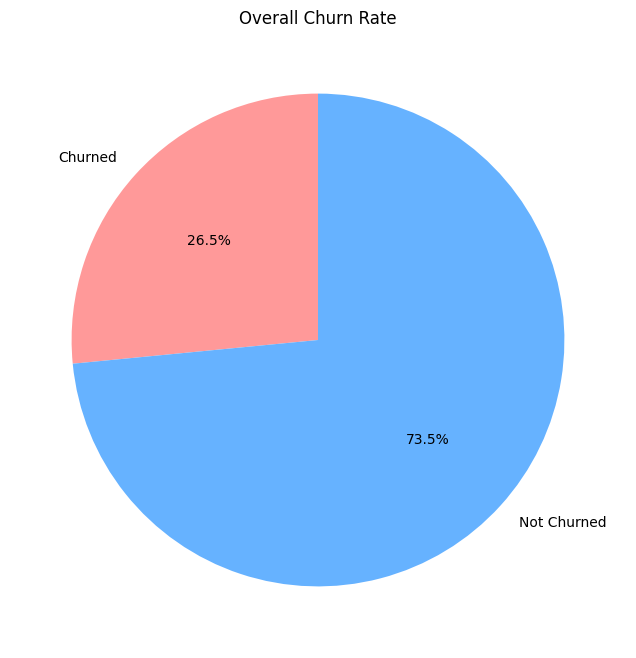

In [43]:
# Plotting Pie Chart

labels = ['Churned', 'Not Churned']
sizes = [churned_customers, total_customers - churned_customers]
colors = ['#FF9999', '#66B2FF'] 

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',  startangle=90)
plt.title('Overall Churn Rate')
plt.show()


__Question 2__

Which InternetService type has the highest number of churned customers?

In [44]:

# Calculate churn rate for each InternetService type
churned_customers_by_internet_service = df.groupby('InternetService')['Churn'].sum()

# Display the churn rates by InternetService type
churned_customers_by_internet_service


InternetService
DSL            171
Fiber optic    570
No              39
Name: Churn, dtype: object

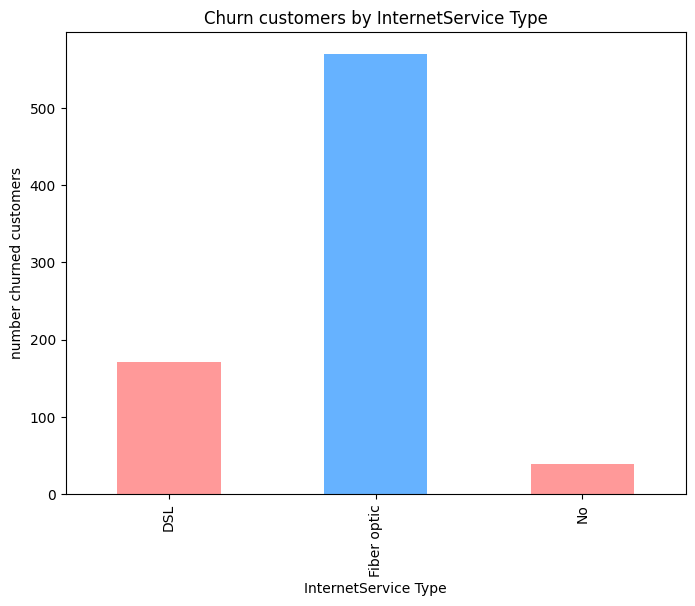

In [45]:
# Plotting Bar Chart
plt.figure(figsize=(8, 6))
churned_customers_by_internet_service.plot(kind='bar', color=['#FF9999', '#66B2FF'])
plt.title('Churn customers by InternetService Type')
plt.xlabel('InternetService Type')
plt.ylabel('number churned customers')
plt.show()

__Question 3__

What is the distribution of customers based on gender, senior citizen status, partner, and dependents?

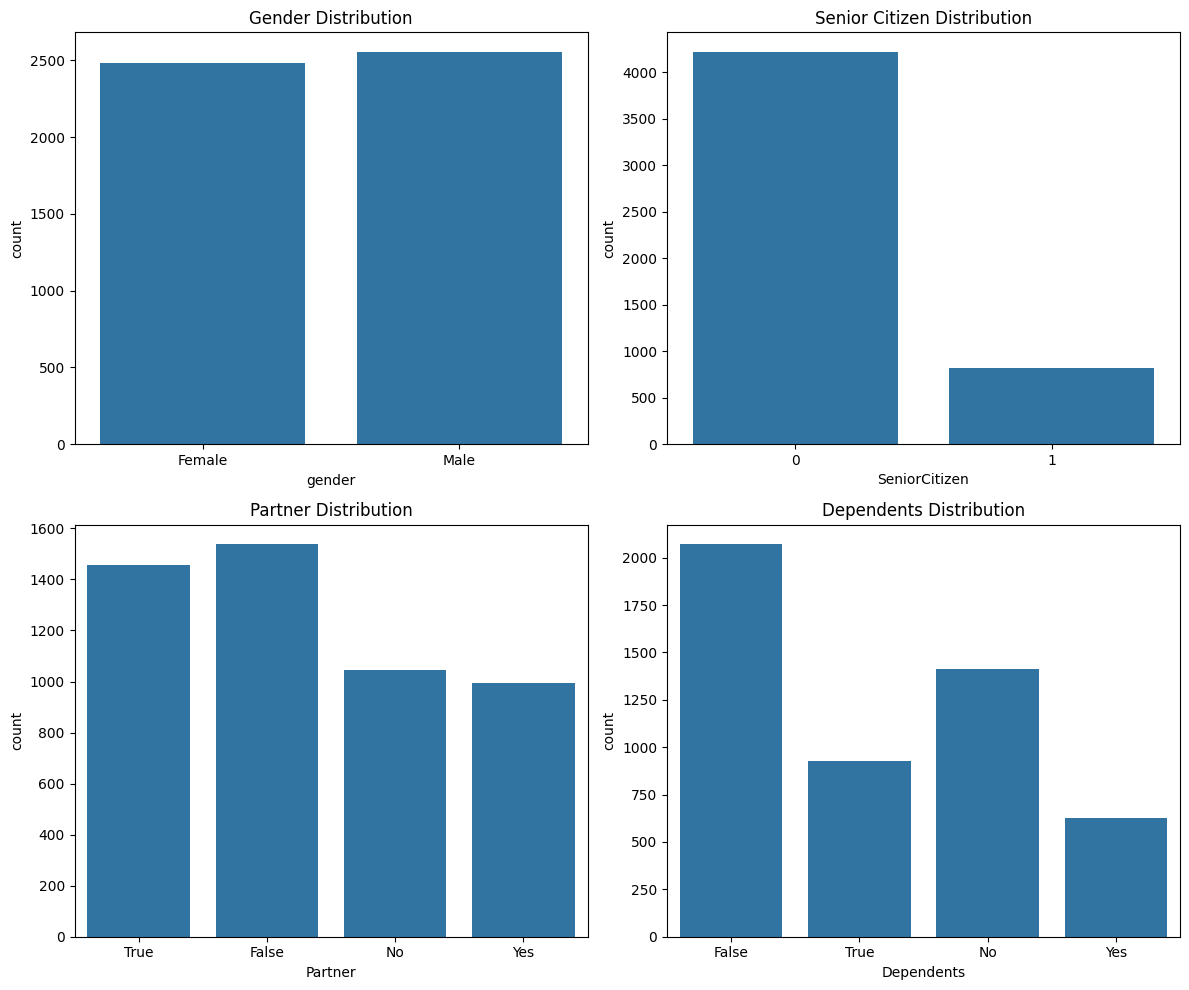

In [46]:

# 1. Demographic Analysis
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

sns.countplot(x='gender', data=data, ax=axes[0, 0])
axes[0, 0].set_title('Gender Distribution')

sns.countplot(x='SeniorCitizen', data=data, ax=axes[0, 1])
axes[0, 1].set_title('Senior Citizen Distribution')

sns.countplot(x='Partner', data=data, ax=axes[1, 0])
axes[1, 0].set_title('Partner Distribution')

sns.countplot(x='Dependents', data=data, ax=axes[1, 1])
axes[1, 1].set_title('Dependents Distribution')

plt.tight_layout()
plt.show()


4. Is there a significant difference in churn rates between customers with month-to-month contracts and those with longer-term contracts?

In [47]:

# Impact of Contract Type on Churn
contract_churn_rates = drop_nan.groupby('Contract')['Churn'].mean()*100

contract_churn_rates


Contract
Month-to-month    43.148688
One year          11.563981
Two year           2.413516
Name: Churn, dtype: object

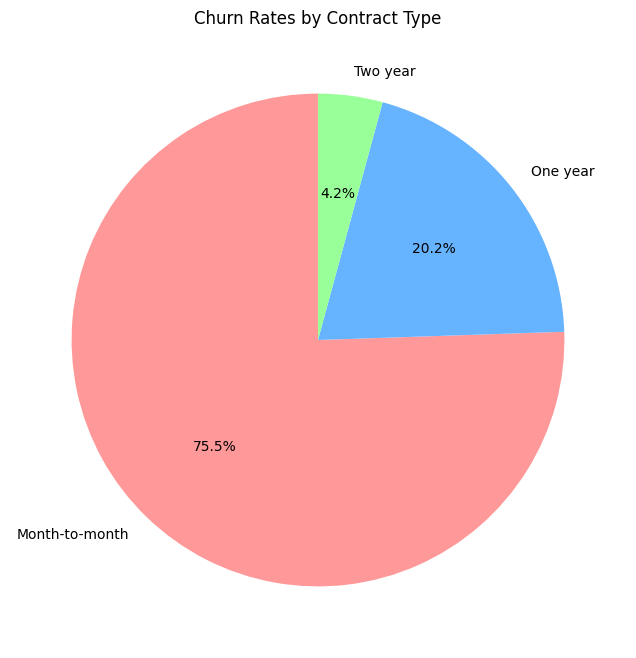

In [48]:

# Pie chart
plt.figure(figsize=(8, 8))
plt.pie(contract_churn_rates, labels=contract_churn_rates.index, autopct='%1.1f%%', startangle=90, colors=['#ff9999', '#66b3ff', '#99ff99'])
plt.title('Churn Rates by Contract Type')
plt.show()

__Question 5__

Are there specific payment methods associated with higher or lower churn?


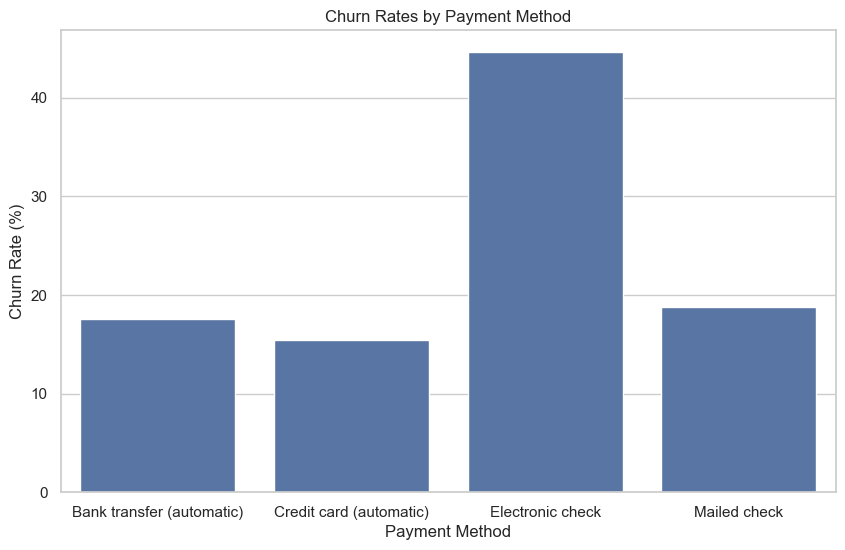

In [49]:


# Set Seaborn style
sns.set(style="whitegrid")

# Are there specific payment methods associated with higher or lower churn?
payment_method_churn_rates = drop_nan.groupby('PaymentMethod')['Churn'].mean()

# Visualization using bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=payment_method_churn_rates.index, y=payment_method_churn_rates.values * 100)
plt.title('Churn Rates by Payment Method')
plt.xlabel('Payment Method')
plt.ylabel('Churn Rate (%)')
plt.show()


__Question 6__

How does the provision of phone service (True/False) influence customer churn?

In [50]:
data['PhoneService'] = data['PhoneService'].replace({'Yes':True,  'No':False})

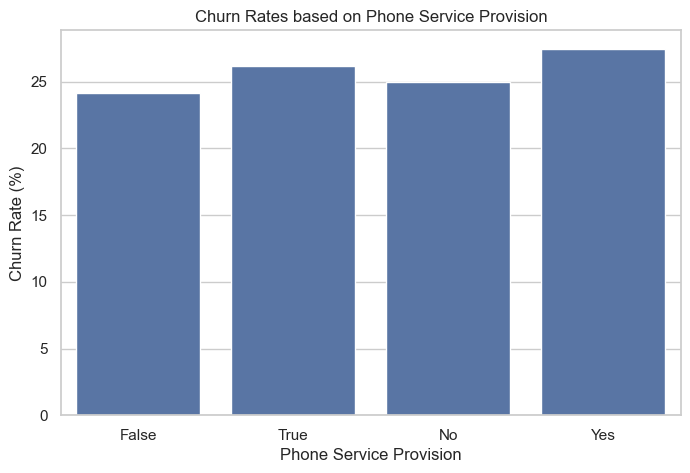

In [51]:


# Set Seaborn style
sns.set(style="whitegrid")

# Churn rates based on PhoneService
phone_churn_rates = drop_nan.groupby('PhoneService')['Churn'].mean()

# Visualization using bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x=phone_churn_rates.index, y=phone_churn_rates.values * 100)
plt.title('Churn Rates based on Phone Service Provision')
plt.xlabel('Phone Service Provision')
plt.ylabel('Churn Rate (%)')
plt.show()


__Hypothesis Testing__


 H0: The tenure of customers has no significant impact on churn.

 H1: Customers with shorter tenure are more likely to churn.

In [52]:
from scipy.stats import ttest_ind


# Selecting data for customers who churned and those who did not
churned_tenure = data[data['Churn'] == True]['tenure']
not_churned_tenure = data[data['Churn'] == False]['tenure']

# Performing a t-test
statistic, p_value = ttest_ind(churned_tenure, not_churned_tenure)

# Print the results
print(f'Test Statistic: {statistic}')
print(f'P-value: {p_value}')

# Set the significance level (alpha)
alpha = 0.05

# Compare p-value with alpha
if p_value < alpha:
    print("Reject the null hypothesis (H0): Customers with shorter tenure are more likely to churn.")
else:
    print("Fail to reject the null hypothesis (H0): The tenure of customers has no significant impact on churn.")


Test Statistic: -26.73190873796306
P-value: 2.543980226346796e-147
Reject the null hypothesis (H0): Customers with shorter tenure are more likely to churn.


__Insights__

+ Customers with shorter tenure are more likely to churn.

+ This means, tenure has significant impact on churn

__Data Preparation__

 Feature Engineering

In [53]:
data.isna().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       267
InternetService       0
OnlineSecurity      649
OnlineBackup        649
DeviceProtection    649
TechSupport         649
StreamingTV         649
StreamingMovies     649
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          0
Churn                 1
dtype: int64

In [54]:
monthlycharges_unique = data['MonthlyCharges'].unique()
monthlycharges_unique

array([ 29.85000038,  56.95000076,  53.84999847, ...,  78.7       ,
        60.65      , 103.2       ])

In [55]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5035 entries, 0 to 5042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5035 non-null   object 
 1   gender            5035 non-null   object 
 2   SeniorCitizen     5035 non-null   int64  
 3   Partner           5035 non-null   object 
 4   Dependents        5035 non-null   object 
 5   tenure            5035 non-null   int64  
 6   PhoneService      5035 non-null   bool   
 7   MultipleLines     4768 non-null   object 
 8   InternetService   5035 non-null   object 
 9   OnlineSecurity    4386 non-null   object 
 10  OnlineBackup      4386 non-null   object 
 11  DeviceProtection  4386 non-null   object 
 12  TechSupport       4386 non-null   object 
 13  StreamingTV       4386 non-null   object 
 14  StreamingMovies   4386 non-null   object 
 15  Contract          5035 non-null   object 
 16  PaperlessBilling  5035 non-null   object 
 17  

In [56]:
data["PaymentMethod"].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

In [57]:
data

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,0,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,0,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,0,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,9237-HQITU,Female,0,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5038,6840-RESVB,Male,0,Yes,Yes,24,True,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.800000,1990.500000,False
5039,2234-XADUH,Female,0,Yes,Yes,72,True,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.200000,7362.900000,False
5040,4801-JZAZL,Female,0,Yes,Yes,11,False,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.600000,346.450000,False
5041,8361-LTMKD,Male,1,Yes,No,4,True,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.400000,306.600000,True


function to handle features with yes/no

In [58]:
def convert_to_boolean(data, columns):
    for column in columns:
        data[column] = data[column].map({'Yes': True, 'No': False, 'No internet service': False}).combine_first(data[column])
    return data


In [59]:
cols = ['OnlineBackup','PaperlessBilling','DeviceProtection','StreamingMovies','StreamingTV','TechSupport','OnlineSecurity','MultipleLines','PhoneService','Dependents','Partner']

convert_to_boolean(data,cols)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,0,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,0,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,0,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,9237-HQITU,Female,0,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5038,6840-RESVB,Male,0,True,True,24,True,True,DSL,True,...,True,True,True,True,One year,True,Mailed check,84.800000,1990.500000,False
5039,2234-XADUH,Female,0,True,True,72,True,True,Fiber optic,False,...,True,False,True,True,One year,True,Credit card (automatic),103.200000,7362.900000,False
5040,4801-JZAZL,Female,0,True,True,11,False,No phone service,DSL,True,...,False,False,False,False,Month-to-month,True,Electronic check,29.600000,346.450000,False
5041,8361-LTMKD,Male,1,True,False,4,True,True,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Mailed check,74.400000,306.600000,True


check unique values in all columns of dataset

In [60]:

# Display unique values for each column
for column in data.columns:
    unique_values = data[column].unique()
    
    print(f"Unique values in column '{column}': {unique_values}")


Unique values in column 'customerID': ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
Unique values in column 'gender': ['Female' 'Male']
Unique values in column 'SeniorCitizen': [0 1]
Unique values in column 'Partner': [True False]
Unique values in column 'Dependents': [False True]
Unique values in column 'tenure': [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26 39]
Unique values in column 'PhoneService': [False  True]
Unique values in column 'MultipleLines': [None False True 'No phone service']
Unique values in column 'InternetService': ['DSL' 'Fiber optic' 'No']
Unique values in column 'OnlineSecurity': [False True None]
Unique values in column 'OnlineBackup': [True False None]
Unique values in column 'DeviceProtection': [False True None]
Unique values in column 'TechSupport': [Fal

In [61]:
data['TotalCharges'].head(30) 

0       29.850000
1     1889.500000
2      108.150002
3     1840.750000
4      151.649994
5      820.500000
6     1949.400024
7      301.899994
8     3046.050049
9     3487.949951
10     587.450012
11     326.799988
12    5681.100098
13    5036.299805
14    2686.050049
15    7895.149902
16    1022.950012
17    7382.250000
18     528.349976
19    1862.900024
20      39.650002
21     202.250000
22      20.150000
23    3505.100098
24    2970.300049
25    1530.599976
26    4749.149902
27      30.200001
28    6369.450195
29    1093.099976
Name: TotalCharges, dtype: float64

Handle missing values in 'TotalCharges' and 'Churn'

In [62]:
# data = data.dropna(subset='TotalCharges')
data = data.dropna(subset='Churn')

In [63]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5034 entries, 0 to 5042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5034 non-null   object 
 1   gender            5034 non-null   object 
 2   SeniorCitizen     5034 non-null   int64  
 3   Partner           5034 non-null   object 
 4   Dependents        5034 non-null   object 
 5   tenure            5034 non-null   int64  
 6   PhoneService      5034 non-null   bool   
 7   MultipleLines     4767 non-null   object 
 8   InternetService   5034 non-null   object 
 9   OnlineSecurity    4385 non-null   object 
 10  OnlineBackup      4385 non-null   object 
 11  DeviceProtection  4385 non-null   object 
 12  TechSupport       4385 non-null   object 
 13  StreamingTV       4385 non-null   object 
 14  StreamingMovies   4385 non-null   object 
 15  Contract          5034 non-null   object 
 16  PaperlessBilling  5034 non-null   object 
 17  

In [64]:
data['PhoneService']= data['PhoneService'].astype(object)

 __DATA PREPARATION__

Split the dataset into features (X) and the target variable (y).

In [65]:

# Separate features and target

X = data.drop(columns=['customerID', 'Churn'],axis=1)

y = data['Churn'].astype(int) # Convert the target variable to integers

In [67]:
data['InternetService'].unique

<bound method Series.unique of 0               DSL
1               DSL
2               DSL
3               DSL
4       Fiber optic
           ...     
5038            DSL
5039    Fiber optic
5040            DSL
5041    Fiber optic
5042    Fiber optic
Name: InternetService, Length: 5034, dtype: object>

Spilt data into training and evaluation

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X ,y ,test_size=0.2, random_state=42 , stratify =y)

In [69]:
X_train

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
3581,Male,0,True,True,68,True,True,Fiber optic,True,True,True,True,True,True,Two year,True,Electronic check,113.150000,7856.000000
1819,Female,0,True,True,61,False,None,DSL,False,True,True,True,True,False,Two year,False,Credit card (automatic),51.349998,3244.399902
423,Male,0,True,True,44,True,True,No,None,None,None,None,None,None,One year,False,Mailed check,25.700001,1110.500000
1491,Female,0,False,False,1,True,False,No,None,None,None,None,None,None,Month-to-month,False,Mailed check,19.549999,19.549999
4143,Male,0,True,True,50,True,False,No,False,False,False,False,False,False,One year,True,Mailed check,20.350000,938.950000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3215,Female,0,True,False,8,True,False,No,False,False,False,False,False,False,Month-to-month,False,Bank transfer (automatic),20.150000,156.250000
4,Female,0,False,False,2,True,False,Fiber optic,False,False,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994
400,Female,0,False,False,32,True,False,No,None,None,None,None,None,None,One year,False,Bank transfer (automatic),19.750000,624.150024
1277,Female,0,True,True,72,True,False,No,None,None,None,None,None,None,Two year,True,Credit card (automatic),20.100000,1326.250000


__Feature Engineering__

In [70]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5034 entries, 0 to 5042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5034 non-null   object 
 1   SeniorCitizen     5034 non-null   int64  
 2   Partner           5034 non-null   object 
 3   Dependents        5034 non-null   object 
 4   tenure            5034 non-null   int64  
 5   PhoneService      5034 non-null   object 
 6   MultipleLines     4767 non-null   object 
 7   InternetService   5034 non-null   object 
 8   OnlineSecurity    4385 non-null   object 
 9   OnlineBackup      4385 non-null   object 
 10  DeviceProtection  4385 non-null   object 
 11  TechSupport       4385 non-null   object 
 12  StreamingTV       4385 non-null   object 
 13  StreamingMovies   4385 non-null   object 
 14  Contract          5034 non-null   object 
 15  PaperlessBilling  5034 non-null   object 
 16  PaymentMethod     5034 non-null   object 
 17  

 specify which columns are numerical and which are categorical. 

In [71]:
# Identify numerical columns

numeric_columns =X.select_dtypes(include='number').columns

numeric_columns


Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')

In [72]:
# Identify categorical columns
categorical_columns = X.select_dtypes(include='object').columns

categorical_columns

Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object')

### Pipelines

In [73]:

# Create transformers for numeric and categorical features

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('bool_to_str', FunctionTransformer(lambda x: x.astype(str))),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])


Create Column Transformer: to apply transformers to the appropriate columns

In [74]:

# Create a ColumnTransformer to apply transformers to the appropriate columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns)
    ]
)

Create a list of models to train and evaluate.

In [75]:

# Define models
models = [
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('Logistic Regression', LogisticRegression(random_state=42)),
    ('Support Vector Machine', SVC(random_state=42, probability=True)),
    ('K-Nearest Neighbors', KNeighborsClassifier()),
    ('Tree-based (Decision Tree)', DecisionTreeClassifier(random_state=42))
]

Train and Evaluate Models:

In [76]:


# checkout the model
for model_name, model in models:
    print(f'{model_name}')
    

Random Forest
Logistic Regression
Support Vector Machine
K-Nearest Neighbors
Tree-based (Decision Tree)


__Balanced Data__

In [77]:

for model_name, model in models:
   
        
 # Create a pipeline with preprocessing, power transformation, and the current model
    pipeline = ImbPipeline(steps=[
            ('preprocessor', preprocessor),
            ('power_transform', PowerTransformer(method='yeo-johnson')),
            ('sampler', RandomOverSampler()),  # Adjust oversampling or undersampling technique
            ('classifier', model)
        ])


    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train)

    # Predict on the test set
    y_pred = pipeline.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} Accuracy: {accuracy:.2f}")
        
    # Print other metrics if needed
    # print("Confusion Matrix:")
    # print(confusion_matrix(y_test, y_pred))
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    print("="*50)

Random Forest Accuracy: 0.78

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       740
           1       0.59      0.58      0.59       267

    accuracy                           0.78      1007
   macro avg       0.72      0.72      0.72      1007
weighted avg       0.78      0.78      0.78      1007

Logistic Regression Accuracy: 0.76

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.75      0.82       740
           1       0.54      0.81      0.65       267

    accuracy                           0.76      1007
   macro avg       0.73      0.78      0.73      1007
weighted avg       0.82      0.76      0.78      1007

Support Vector Machine Accuracy: 0.74

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.74      0.81       740
           1       0.51      0.76      0.61       267

    accu

In [83]:

# Create a folder to save models if it doesn't exist
folder_path = 'saved_models'
os.makedirs(folder_path, exist_ok=True)

# Save each model
for name, model in models:
    filename = os.path.join(folder_path, f'{name.replace(" ", "_").lower()}_model.joblib')
    joblib.dump(model, filename)

In [ ]:
pd.DataFrame(preprocessor.fit_transform(X_train))

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
0,-0.43671,1.444677,1.597538,2.457884,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1,-0.43671,1.158312,-0.458791,0.416487,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
2,-0.43671,0.462853,-1.312268,-0.528117,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,-0.43671,-1.296247,-1.516902,-1.011043,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,-0.43671,0.708309,-1.490283,-0.604056,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4022,-0.43671,-1.009882,-1.496938,-0.950531,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4023,-0.43671,-1.255338,0.185059,-0.952567,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4024,-0.43671,-0.028058,-1.510247,-0.743407,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4025,-0.43671,1.608314,-1.498602,-0.432612,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


### Feature Importance and Selection

In [ ]:
from sklearn.feature_selection import SelectKBest,mutual_info_classif

selection = SelectKBest(mutual_info_classif, k=20)

In [ ]:

for model_name, model in models:
   
        
 # Create a pipeline with preprocessing, power transformation, and the current model
    pipeline = ImbPipeline(steps=[
            ('preprocessor', preprocessor),
            ('feature_selection', selection),
            ('power_transform', PowerTransformer(method='yeo-johnson')),
            # ('sampler', RandomUnderSampler()),  # Adjust oversampling or undersampling technique
            ('classifier', model)
        ])


    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train)

    # Predict on the test set
    y_pred = pipeline.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} Accuracy: {accuracy:.2f}")
        
    # Print other metrics if needed
    # print("Confusion Matrix:")
    # print(confusion_matrix(y_test, y_pred))
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    print("="*50)

Random Forest Accuracy: 0.79

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       740
           1       0.62      0.51      0.56       267

    accuracy                           0.79      1007
   macro avg       0.72      0.70      0.71      1007
weighted avg       0.78      0.79      0.78      1007

Logistic Regression Accuracy: 0.80

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.87       740
           1       0.64      0.53      0.58       267

    accuracy                           0.80      1007
   macro avg       0.74      0.71      0.72      1007
weighted avg       0.79      0.80      0.79      1007

Support Vector Machine Accuracy: 0.80

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       740
           1       0.66      0.50      0.57       267

    accu

In [ ]:
selected_feature_indices = selection.get_support(indices=True)
selected_feature_indices

array([ 1,  2,  3,  8,  9, 16, 17, 18, 19, 22, 23, 28, 29, 30, 37, 38, 39,
       40, 41, 44], dtype=int64)

### ROC

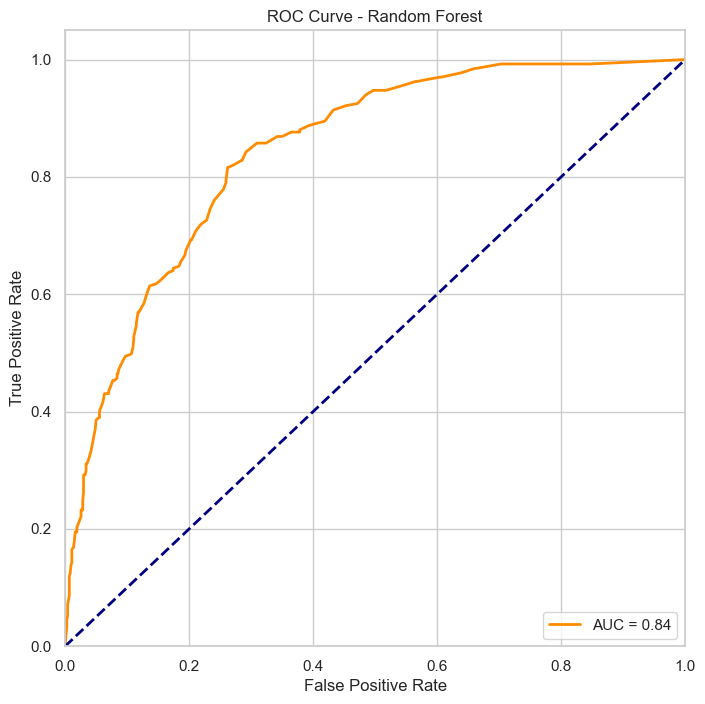

Random Forest Metrics:
Accuracy: 0.79
Confusion Matrix:
[[661  79]
 [134 133]]




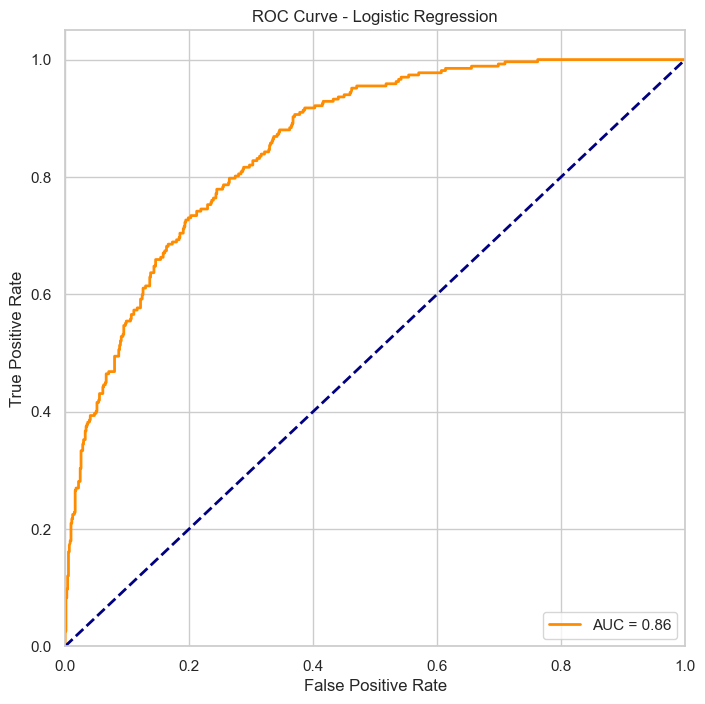

Logistic Regression Metrics:
Accuracy: 0.81
Confusion Matrix:
[[670  70]
 [125 142]]




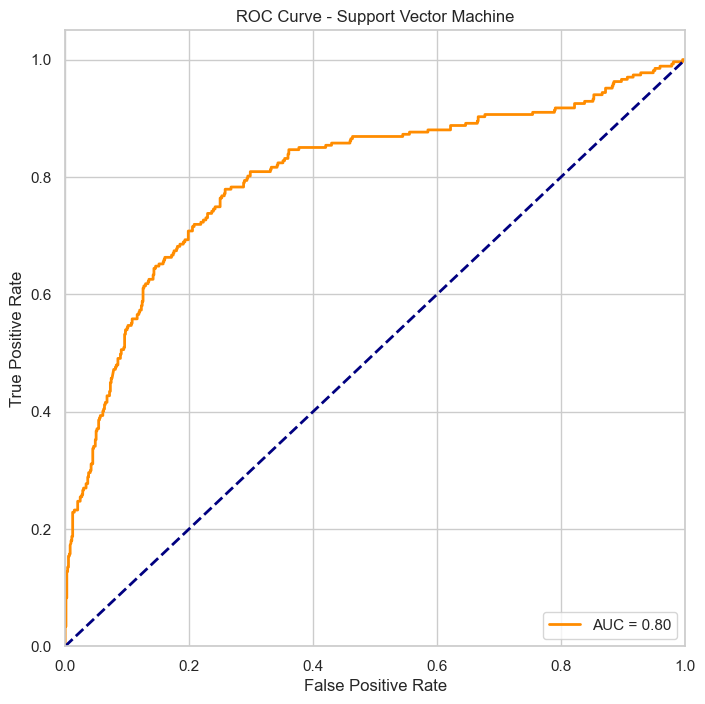

Support Vector Machine Metrics:
Accuracy: 0.80
Confusion Matrix:
[[677  63]
 [136 131]]




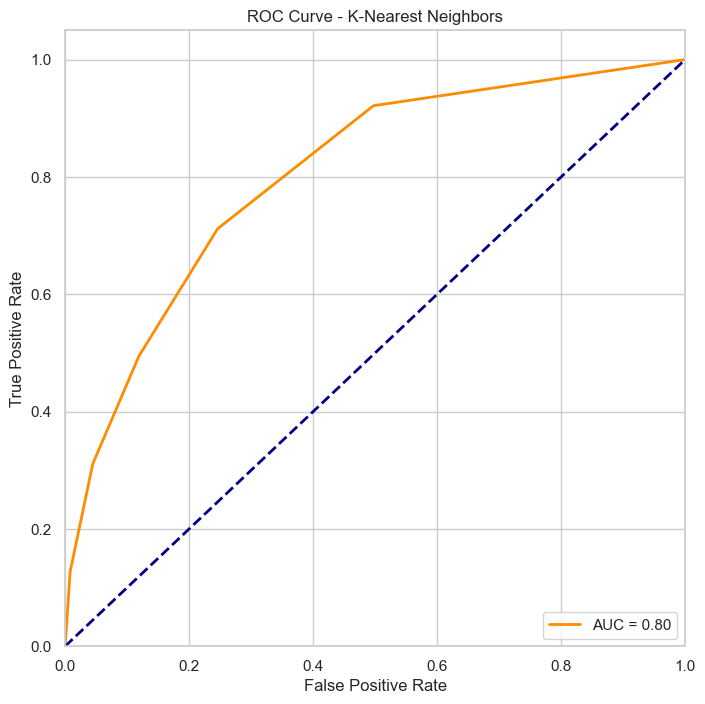

K-Nearest Neighbors Metrics:
Accuracy: 0.78
Confusion Matrix:
[[652  88]
 [135 132]]




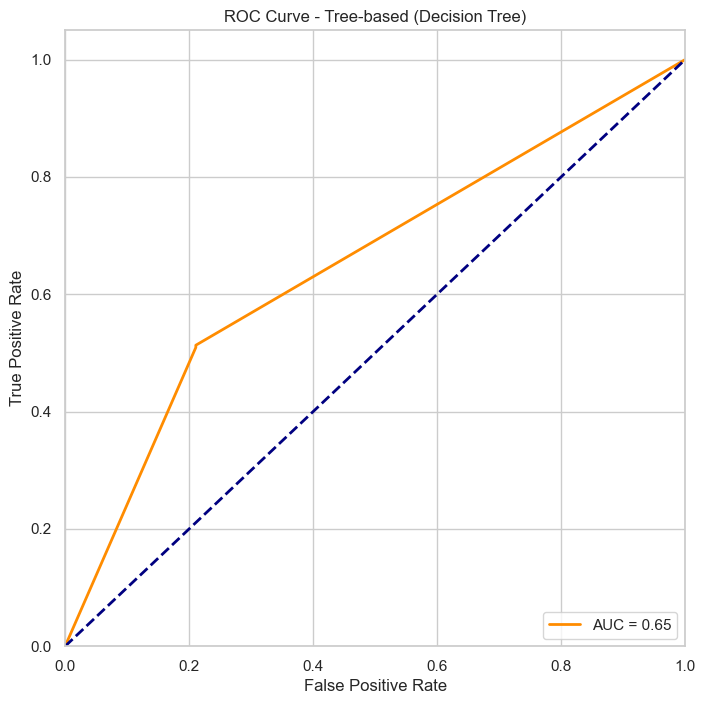

Tree-based (Decision Tree) Metrics:
Accuracy: 0.71
Confusion Matrix:
[[584 156]
 [131 136]]




In [ ]:
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'models' is a list of tuples containing model name and model instance
for model_name, model in models:
    # Create a pipeline with preprocessing, power transformation, and the current model
    pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('feature_selection', selection),
        ('power_transform', PowerTransformer(method='yeo-johnson')),
        # ('sampler', RandomUnderSampler()),  # Adjust oversampling or undersampling technique
        ('classifier', model)
    ])

    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train)

    # Predict probabilities for the positive class
    y_scores = pipeline.predict_proba(X_test)[:, 1]

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.show()

    # Predict on the test set
    y_pred = pipeline.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    confusion_mat = confusion_matrix(y_test, y_pred)

    print(f"{model_name} Metrics:")
    print(f"Accuracy: {accuracy:.2f}")
    print("Confusion Matrix:")
    print(confusion_mat)
    print("\n")


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# Define the pipeline with preprocessing, power transformation, and the classifier
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', selection),
    ('power_transform', PowerTransformer(method='yeo-johnson')),
    # ('sampler', RandomUnderSampler()),  # Adjust oversampling or undersampling technique
    ('classifier', RandomForestClassifier())
])

# Define the hyperparameter grid to search
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    # Add other hyperparameters to tune
}

# Set up GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# Perform hyperparameter search
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Get the best model
best_model = grid_search.best_estimator_

# Evaluate on the test set
test_accuracy = best_model.score(X_test, y_test)

print("Best Hyperparameters:", best_params)
print("Test Accuracy:", test_accuracy)


Best Hyperparameters: {'classifier__max_depth': None, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 50}
Test Accuracy: 0.7894736842105263
